In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[INFO] loading images...
[INFO] data matrix: 3998 images (937.03MB)
[INFO] class labels:
1. Aidai
2. Anhu
3. Mask
4. NoMask
5. axin
6. baijingting
7. baike
8. baojianfeng
9. caiyilin
10. caizhuoyan
11. caobingkun
12. caoying
13. chenbailin
14. ditianlin
15. dongjie
16. dongxuan
17. fanbingbing
18. fanwei
19. haiqing
20. hanxue
21. huangbo
22. zhouxingchi
[INFO] compiling model...
[INFO] training network...
Epoch 1/50
99/99 [==============================] - ETA: 0s - batch: 49.0000 - size: 31.9798 - loss: 0.5815 - accuracy: 0.7303

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


99/99 [==============================] - 42s 80ms/step - batch: 49.0000 - size: 31.9798 - loss: 0.5815 - accuracy: 0.7303 - val_loss: 0.2226 - val_accuracy: 0.9534
Epoch 2/50
99/99 [==============================] - 8s 84ms/step - batch: 49.0000 - size: 31.9798 - loss: 0.2106 - accuracy: 0.9455 - val_loss: 0.4723 - val_accuracy: 0.9534
Epoch 3/50
99/99 [==============================] - 8s 82ms/step - batch: 49.0000 - size: 31.9798 - loss: 0.1907 - accuracy: 0.9485 - val_loss: 0.2375 - val_accuracy: 0.9472
Epoch 4/50
99/99 [==============================] - 8s 83ms/step - batch: 49.0000 - size: 31.9798 - loss: 0.1846 - accuracy: 0.9493 - val_loss: 0.4706 - val_accuracy: 0.8814
Epoch 5/50
99/99 [==============================] - 8s 84ms/step - batch: 49.0000 - size: 31.9798 - loss: 0.1748 - accuracy: 0.9498 - val_loss: 0.2711 - val_accuracy: 0.9446
Epoch 6/50
99/99 [==============================] - 8s 83ms/step - batch: 49.0000 - size: 31.9798 - loss: 0.1698 - accuracy: 0.9508 - val_lo

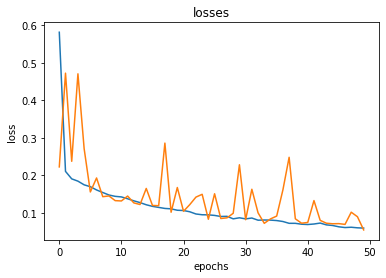

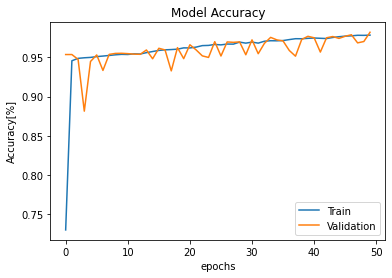

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import tensorflow as tf
tf.test.is_gpu_available()

class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation(finalAct))
		return model
		# return the constructed network architectu


# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.get_backend()
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import numpy as np
import argparse
import random
import pickle
import cv2
import os

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (100, 100, 3)
# disable eager execution
tf.compat.v1.disable_eager_execution()

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/Colab Notebooks/Trial3/DatasetMLC")))
random.seed(42)
random.shuffle(imagePaths)
# initialize the data and labels
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)
	# extract set of class labels from the image path and update the
	# labels list
	l = label = imagePath.split(os.path.sep)[-2].split("_")
	labels.append(l)
 
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# initialize the model using a sigmoid activation as the final layer
# in the network so we can perform multi-label classification
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=len(mlb.classes_),finalAct="sigmoid")
# initialize the optimizer (SGD is sufficient)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)        

# plot the training loss
plt.plot(H.history['loss'], label = "Train") 
plt.plot(H.history['val_loss'], label = "Validation")
plt.title("losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
# plot the training accuracy
plt.plot(H.history['accuracy'], label = "Train")
plt.plot(H.history['val_accuracy'], label = "Validation") 
plt.title("Model Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy[%]")
plt.legend()
plt.show()


[INFO] classifying image...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Aidai: 0.00%
Anhu: 0.03%
Mask: 100.00%
NoMask: 0.00%
axin: 0.08%
baijingting: 3.03%
baike: 1.57%
baojianfeng: 0.17%
caiyilin: 0.31%
caizhuoyan: 0.13%
caobingkun: 0.06%
caoying: 0.00%
chenbailin: 0.01%
ditianlin: 94.35%
dongjie: 0.00%
dongxuan: 0.00%
fanbingbing: 1.41%
fanwei: 0.00%
haiqing: 0.00%
hanxue: 0.00%
huangbo: 2.67%
zhouxingchi: 0.01%


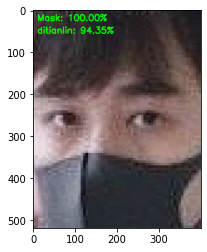

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import imutils
import pickle
import cv2
import os

#predict one image
# load the image
#path2 = filedialog.askopenfilename()
#image = cv2.imread(path2)
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Trial3/DatasetMLC/Mask_ditianlin/0_0_26.jpg")
output = imutils.resize(image, width=400)
 
# pre-process the image for classification
image = cv2.resize(image, (100, 100))
#imshow image
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# classify the input image then find the indexes of the two class
# labels with the *largest* probability
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:2]

# loop over the indexes of the high confidence class labels
for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
	label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
	cv2.putText(output, label, (10, (i * 30) + 25), 
		cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
# show the probabilities for each of the individual labels
for (label, p) in zip(mlb.classes_, proba):
	print("{}: {:.2f}%".format(label, p * 100))
# show the output image
# load image using cv2....and do processing.
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()
     

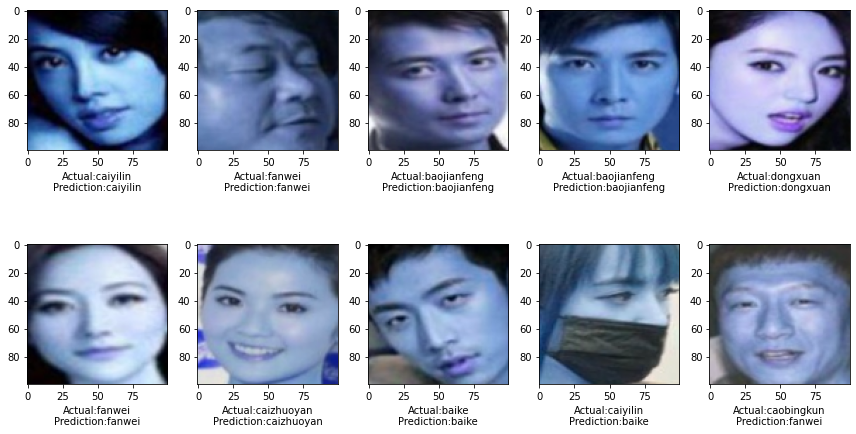

In [ ]:
#run until the mask image comeout because the image is choose randomly
plt.figure(figsize=(12,7))
y_pred = model.predict(testX)
for i in range(10):
    sample = random.choice(range(len(testX)))
    image = testX[sample]
    category = testY[sample]
    pred = y_pred[sample]
    truelabel = np.argsort(category)[::-1][:2]
    predlabel = np.argsort(pred)[::-1][:2]

    if truelabel[1]>4:
      truelabel = truelabel[1]
    else:
      truelabel = truelabel[0]

    if predlabel[1] > 4:
      predlabel = predlabel[1]
    else:
      predlabel = predlabel[0]

    if truelabel== 0:
        label = "Aidai"
    elif truelabel==1:
        label = "Anhu"
    elif truelabel==2:
        label = "undefined"    
    elif truelabel==3:
        label = "undefined"
    elif truelabel==4:
        label = "Axin"
    elif truelabel==5:
        label = "baijingting"    
    elif truelabel==6:
        label = "baike"
    elif truelabel==7:
        label = "baojianfeng"
    elif truelabel==8:
        label = "caiyilin"    
    elif truelabel==9:
        label = "caizhuoyan"
    elif truelabel==10:
        label = "caobingkun"
    elif truelabel==11:
        label = "caoying"    
    elif truelabel==12:
        label = "chenbailin"
    elif truelabel==13:
        label = "ditianlin"
    elif truelabel==14:
        label = "dongjie"    
    elif truelabel==15:
        label = "dongxuan"
    elif truelabel==16:
        label = "fanbingbing"
    elif truelabel==17:
        label = "fanwei"    
    elif truelabel==18:
        label = "haiqing"
    elif truelabel==19:
        label = "fanwei"    
    elif truelabel==20:
        label = "haiqing"
    elif truelabel==21:
        label = "hanxue"    
    elif truelabel==22:
        label = "huangbo"
    else:
        label = "zhouxingchi"

    if predlabel== 0:
        pred_label = "Aidai"
    elif predlabel==1:
        pred_label = "Anhu"
    elif predlabel==2:
        pred_label = "undefined"    
    elif predlabel==3:
        pred_label = "undefined"
    elif predlabel==4:
        pred_label = "Axin"
    elif predlabel==5:
        pred_label = "baijingting"    
    elif predlabel==6:
        pred_label = "baike"
    elif predlabel==7:
        pred_label = "baojianfeng"
    elif predlabel==8:
        pred_label = "caiyilin"    
    elif predlabel==9:
        pred_label = "caizhuoyan"
    elif predlabel==10:
        pred_label = "caobingkun"
    elif predlabel==11:
        pred_label = "caoying"    
    elif predlabel==12:
        pred_label = "chenbailin"
    elif predlabel==13:
        pred_label = "ditianlin"
    elif predlabel==14:
        pred_label = "dongjie"    
    elif predlabel==15:
        pred_label = "dongxuan"
    elif predlabel==16:
        pred_label = "fanbingbing"
    elif predlabel==17:
        pred_label = "fanwei"    
    elif predlabel==18:
        pred_label = "haiqing"
    elif predlabel==19:
        pred_label = "fanwei"    
    elif predlabel==20:
        pred_label = "haiqing"
    elif predlabel==21:
        pred_label = "hanxue"    
    elif predlabel==22:
        pred_label = "huangbo"
    else:
        pred_label = "zhouxingchi"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 
    

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 33, 33, 64)        0